# Assignment 7

## Find a single-humped dataset on the Web. The most original datasets will get a bonus. Compute the histogram, and make it look pretty.

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [178]:
data = pd.read_csv("Korean_demographics_2000-2022.csv")
data

,Date,Region,Birth,Birth_rate,Death,Death_rate,Divorce,Divorce_rate,Marriage,Marriage_rate,Natural_growth,Natural_growth_rate
0,1/1/2000,Busan,3752.0,11.61,1875.0,5.8,814.0,2.5,2435.0,7.5,1877.0,5.8
1,1/1/2000,Chungcheongbuk-do,1903.0,15.06,924.0,7.3,220.0,1.7,828.0,6.6,979.0,7.7
2,1/1/2000,Chungcheongnam-do,2398.0,14.75,1466.0,9.0,321.0,2.0,1055.0,6.5,932.0,5.7
3,1/1/2000,Daegu,3057.0,14.39,1117.0,5.3,422.0,2.0,1577.0,7.4,1940.0,9.1
4,1/1/2000,Daejeon,1859.0,16.08,565.0,4.9,280.0,2.4,868.0,7.5,1294.0,11.2
...,...,...,...,...,...,...,...,...,...,...,...,...
4855,6/1/2022,Jeollanam-do,565.0,3.80,1369.0,9.1,299.0,2.0,479.0,3.2,-805.0,-5.4
4856,6/1/2022,Sejong,248.0,7.90,106.0,3.4,43.0,1.4,123.0,3.9,141.0,4.5
4857,6/1/2022,Seoul,3137.0,4.10,3631.0,4.7,1088.0,1.4,2630.0,3.4,-494.0,-0.6
4858,6/1/2022,Ulsan,443.0,4.80,434.0,4.7,154.0,1.7,316.0,3.5,9.0,0.1


In [179]:
data = data.Marriage_rate
data.fillna(value = data.mean(), inplace=True)
data

0       7.5
1       6.6
2       6.5
3       7.4
4       7.5
       ... 
4855    3.2
4856    3.9
4857    3.4
4858    3.5
4859    3.5
Name: Marriage_rate, Length: 4860, dtype: float64

Here is the histogram of Marriage_rate of Korean_demographics_2000-2022

<AxesSubplot:>

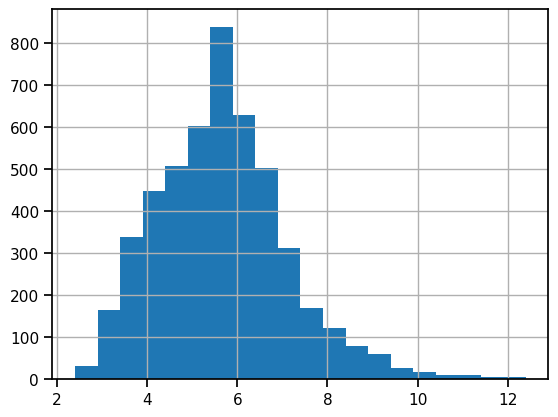

In [180]:
data.hist(bins=20)

## Figure out the best possible match using MLE to find the best parameters.

In [181]:
from scipy.special import psi, polygamma

# Note that log_mean and mean_log are parameters of the dlgamma function
dlgamma = lambda m, log_mean, mean_log: np.log(m) - psi(m) - log_mean + mean_log
dl2gamma = lambda m, *args: 1./m - polygamma(1, m)

In [182]:
data.mean()

5.608451900615842

In [183]:
import numpy as np

where `log_mean` and `mean_log` are $\log{\bar{x}}$ and $\overline{\log(x)}$, respectively.

In [184]:
# Calculate statistics
log_mean = np.log(data.mean())
mean_log = data.apply(np.log).mean()
log_mean, mean_log

(1.7242747279080064, 1.6915311684117877)

In [185]:
# Alpha MLE for Dataset
from scipy.optimize import newton
alpha_mle = newton(dlgamma, 2, dl2gamma, args=(log_mean, mean_log))
alpha_mle

15.434996448584126

In [186]:
# Beta MLE for Dataset
beta_mle = data.mean()/alpha_mle
beta_mle

0.3633594552028752

Let's plot the model

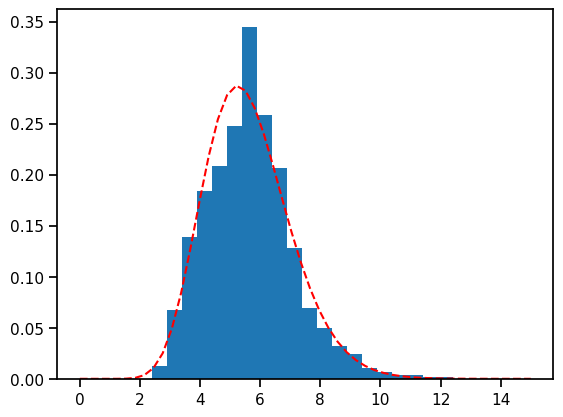

In [155]:
from scipy.stats.distributions import gamma

data.hist(density=True, bins=20, grid=False)
x = np.linspace(0, 15)
plt.plot(x, gamma.pdf(x, a = alpha_mle, scale = beta_mle), 'r--')

## Now, repeat the experiment with Bayesian simulation using PyMC3.

We use normal distribution to model parameter alpha

In [187]:
from pymc3 import Model, Uniform, Normal, Gamma

with Model() as data_model:
    alpha = Normal('alpha', alpha_mle, sd=10)

And we use normal distribution to model parameter beta

In [188]:
with data_model:
    beta = Normal('beta', beta_mle, sd=10)

Now go ahead and model our dataset in pymc3:

In [189]:
with data_model:
    data_like = Gamma('data_like', alpha = alpha_mle, beta = beta_mle, observed=data)

Fit the model

In [190]:
from pymc3 import fit
import seaborn as sns
sns.set_context('notebook')
RANDOM_SEED = 20090425

with data_model: 
    data_trace = fit(random_seed=RANDOM_SEED).sample(1000)

Finished [100%]: Average Loss = 95,294


Now plot all the distributions

/Users/muhenan/opt/anaconda3/envs/cv2/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


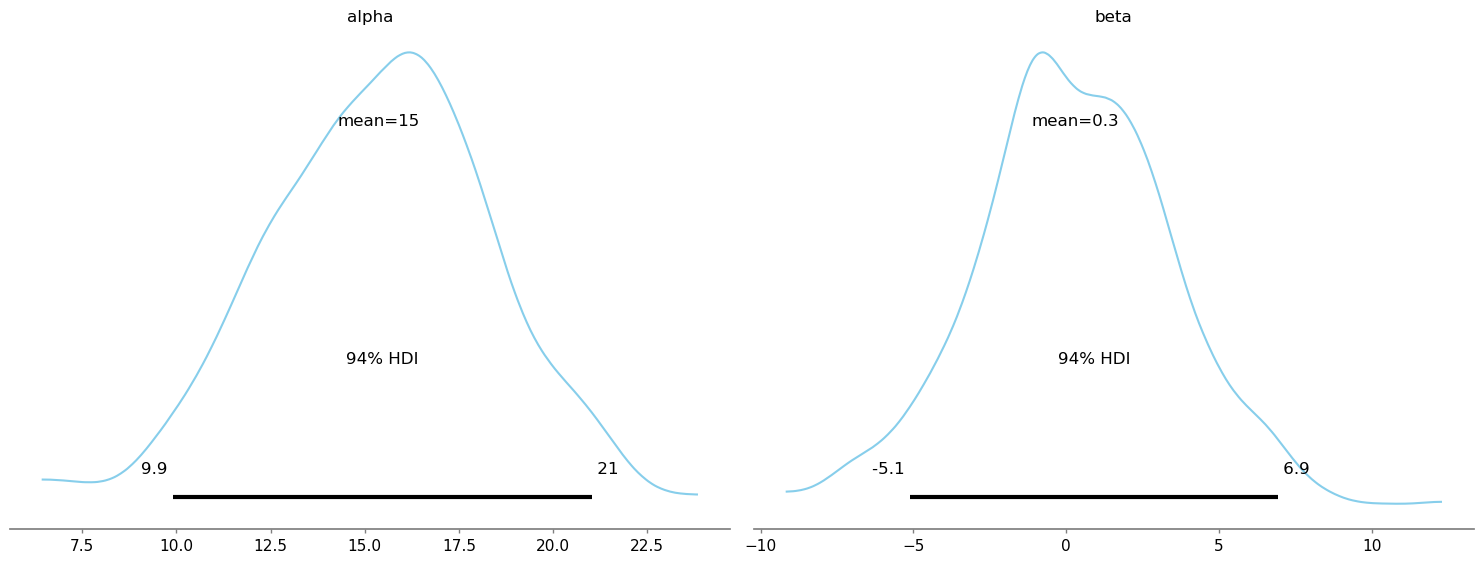

In [191]:
from pymc3 import plot_posterior

plot_posterior(data_trace[100:],
                var_names=['alpha', 'beta'],
                color='#87ceeb');

## Which method is more correct, and which was the most fun?